# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Image Classification using Multi Layer Perceptron

## Learning Objectives

At the end of the experiment, you will be able to :

* load and extract features of images

* implement the Multi-Layer perceptron to classify images

* implement simple neural network from keras

## Introduction

Traffic sign recognition is a challenging, real-world problem relevant for AI based transportation systems. Traffic signs show a wide range of variations between classes in terms of color, shape, and the presence of pictograms or text. However, there exist subsets of
classes (e.g., speed limit signs) that are very similar to each other. Further, the classifier
has to be robust against large variations in visual appearances due to changes in illumination, partial
occlusions, rotations, weather conditions etc. Using a comprehensive traffic sign detection dataset, here we will perform classification of traffic signs, train and evaluate the different models and compare to the performance of MLPs.

![img](https://paperswithcode.com/media/datasets/GTSRB-0000000633-9ce3c5f6_Dki5Rsf.jpg)

## Dataset

The data for this mini-project is from the German Traffic Sign Detection Benchmark [GTSDB](https://benchmark.ini.rub.de/gtsdb_dataset.html). This archive contains the training set used during the IJCNN 2013 competition.

The German Traffic Sign Detection Benchmark is a single-image detection assessment for researchers with interest in the field of computer vision, pattern recognition and image-based driver assistance. It is introduced on the IEEE International Joint Conference on Neural Networks 2013.

It features ...

* The main archive FullIJCNN2013.zip includes the images (1360 x 800 pixels) in PPM format, the image sections containing only the traffic signs
* A file in CSV format with the ground truth
* A ReadMe.txt with more details.

Note that we will be using the images inside the image sections subfolders, containing only the traffic signs.

## Problem Statement

To build and improve upon a machine learning model for the classification of images and achieve a high accuracy final model.

## Grading = 10 Points

### Import Required packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from skimage.io import imread, imshow
from sklearn import preprocessing
import os, glob
from PIL import Image
from sklearn.model_selection import GridSearchCV
# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# Skimage -Image processing
from skimage.exposure import histogram
from skimage.feature import hog
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
# Other Imports
import os
import pickle

### Data Loading and Feature Extraction (2 points)

#### Get the features and labels of data

* Extract the features of the images within image sections only (do not use images located outside these folders)
* Extract labels of the images
* Resize the images to (30, 30) and convert to numpy 1-D array

   Hint: [Link](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/)

In [2]:
import os

FOLDER = "FullIJCNN2013/"
ANNOTATION = 'gt.txt'
CLASSLABELS = 'class_labels.txt'
dirs = os.listdir(FOLDER)
resize_image = (30,30)
#print(dirs)

def extract_class_labels(dirs):
    '''Returns class label names from class_labels.txt file
    '''
    class_labels = {}
    path = os.path.join(FOLDER,CLASSLABELS)
    file_temp = open(path, 'r')
    Lines = file_temp.readlines()
    for line in Lines:
        lbl, names = line.split('=')
        lbl = int(lbl.rstrip())
        names = names.lstrip().rstrip()
        class_labels.update({lbl:names})
    return class_labels

def file_to_df (dirs):
    '''Import files, Extracts images from scenes, returns dataframe.
    '''
    path = os.path.join(FOLDER,ANNOTATION)
    file_tmp = open(path, 'r')
    Lines = file_tmp.readlines()
    labels = get_image_labels(Lines)
    class_labels = extract_class_labels(dirs)
    #print(labels)
    df = [['numpy image', 'hog data', 'histogram', 'label', 'file_name', 'class name']]
    for file in dirs:
        if file.endswith(".ppm"):
            path = os.path.join(FOLDER,file)
            # Opening image
            image = Image.open(path)
            #print('Shape of original image: ', image.size)
            # get bounding box coordinates
            try: 
                a, b, c, d = labels[file][:-1]
                # get labels
                lbl = labels[file][-1]
            except: continue
            #print('B-Box coord: {}, label: {}'.format((a,b,c,d),class_labels[lbl]))
            # create a cropped image with bounding box
            cropped_image = image.crop((a,b,c,d))
            #print('Shape of cropped_image: ', cropped_image.size)
            # resize the image
            cropped_image = cropped_image.resize(resize_image)
            #print(cropped_image.size)
            # Grayscale image
            grey_image = cropped_image.convert(mode= 'L')
            #cropped_image.show()
            # Performing numpy operations
            np_data = np_im_process(grey_image)
            #print('Shape of np_data: ', np_data.shape)
            hog_data = get_hog_features(grey_image)
            #print('Shape of hog_data: ', hog_data.shape)
            hist_data = get_color_histogram(cropped_image)
            #print('Shape of hist_data: ', hist_data.shape)
            #break
            df.append([np_data, hog_data, hist_data, lbl, file.split('.')[0], class_labels[lbl]])
    return np.vstack(df)
            
def np_im_process (image):
    '''Returns numpy array from image.
    ATTRIBUTES
    image: image formatted to desired shape
    '''
    # convert image to numpy array
    data = np.asarray(image)
    # summarize shape
    #print('Shape of Input Grayscale image: ', data.shape)
    
    return data.flatten()

def get_image_labels (Lines):
    '''Reads lines of the .txt file containing lables.
    ATTRIBUTES
    Lines: [file_name; b_box_a; b_box_b; b_box_c; b_box_d; Class_label]
    RETURNS
    labels: {file_name: [a,b,c,d,lbl]}
    '''
    labels = {}
    for line in Lines:
        file_name, a, b, c, d, lbl = line.split(';')
        lbl = lbl[:-1]
        labels.update({file_name: list(map(int,[a, b, c, d, lbl]))})
    return labels

def get_hog_features(image):
    '''https://thepythoncode.com/article/hog-feature-extraction-in-python
    '''
    data = hog(image, orientations=9, pixels_per_cell=(4, 4),
                	cells_per_block=(2, 2), feature_vector= True)
    return data


def get_color_histogram(color_image):
    r, g, b = color_image.split()
    h_grams = np.array([r.histogram(), g.histogram(), b.histogram()])
    #print(h_grams)
    return h_grams.flatten()


if __name__== "__main__":
    #class_labels = extract_class_labels(dirs)
    #print('Class label dictionary: ',class_labels)
    df = file_to_df(dirs)
    # Open a file and use dump() 
    with open('GTSDB.pkl', 'wb') as file: 
        # A new file will be created 
        pickle.dump(df, file) 

### Data Exploration and Preprocessing ( 2 points)

#### Plot the sample image of each class

Hint: plt.subplot

In [2]:
# Load Pickle file
# Open the file in binary mode 
with open('GTSDB.pkl', 'rb') as file: 
    # Call load method to deserialze 
    df = pickle.load(file) 
df2 = pd.DataFrame(df)
df2.columns= df2.iloc[0]
df2 = df2[1:]
df2 = df2.reset_index(drop=True)
df2.to_csv('df.csv', header=True, index=False)

In [3]:
df2.head()

,numpy image,hog data,histogram,label,file_name,class name
0,"[102, 108, 105, 80, 67, 68, 68, 203, 255, 255,...","[0.10452954518914803, 0.13565473746057752, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,00000,priority at next intersection (danger)
1,"[222, 224, 254, 255, 255, 254, 254, 254, 255, ...","[0.06466393925456124, 0.052403263828257315, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,00001,give way (other)
2,"[255, 204, 75, 243, 140, 149, 245, 127, 49, 37...","[0.2862727907224903, 0.0, 0.0, 0.0, 0.00403201...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",39,00002,keep left (mandatory)
3,"[249, 194, 143, 148, 133, 115, 134, 205, 225, ...","[0.24538345358050195, 0.030109626983662076, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21,00003,bend (danger)
4,"[255, 247, 238, 251, 248, 199, 143, 95, 127, 1...","[0.18271324642070286, 0.1361120632753625, 0.11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,00004,speed limit 50 (prohibitory)


In [4]:
print('Shape of dataframe: ', df2.shape)

Shape of dataframe:  (741, 6)


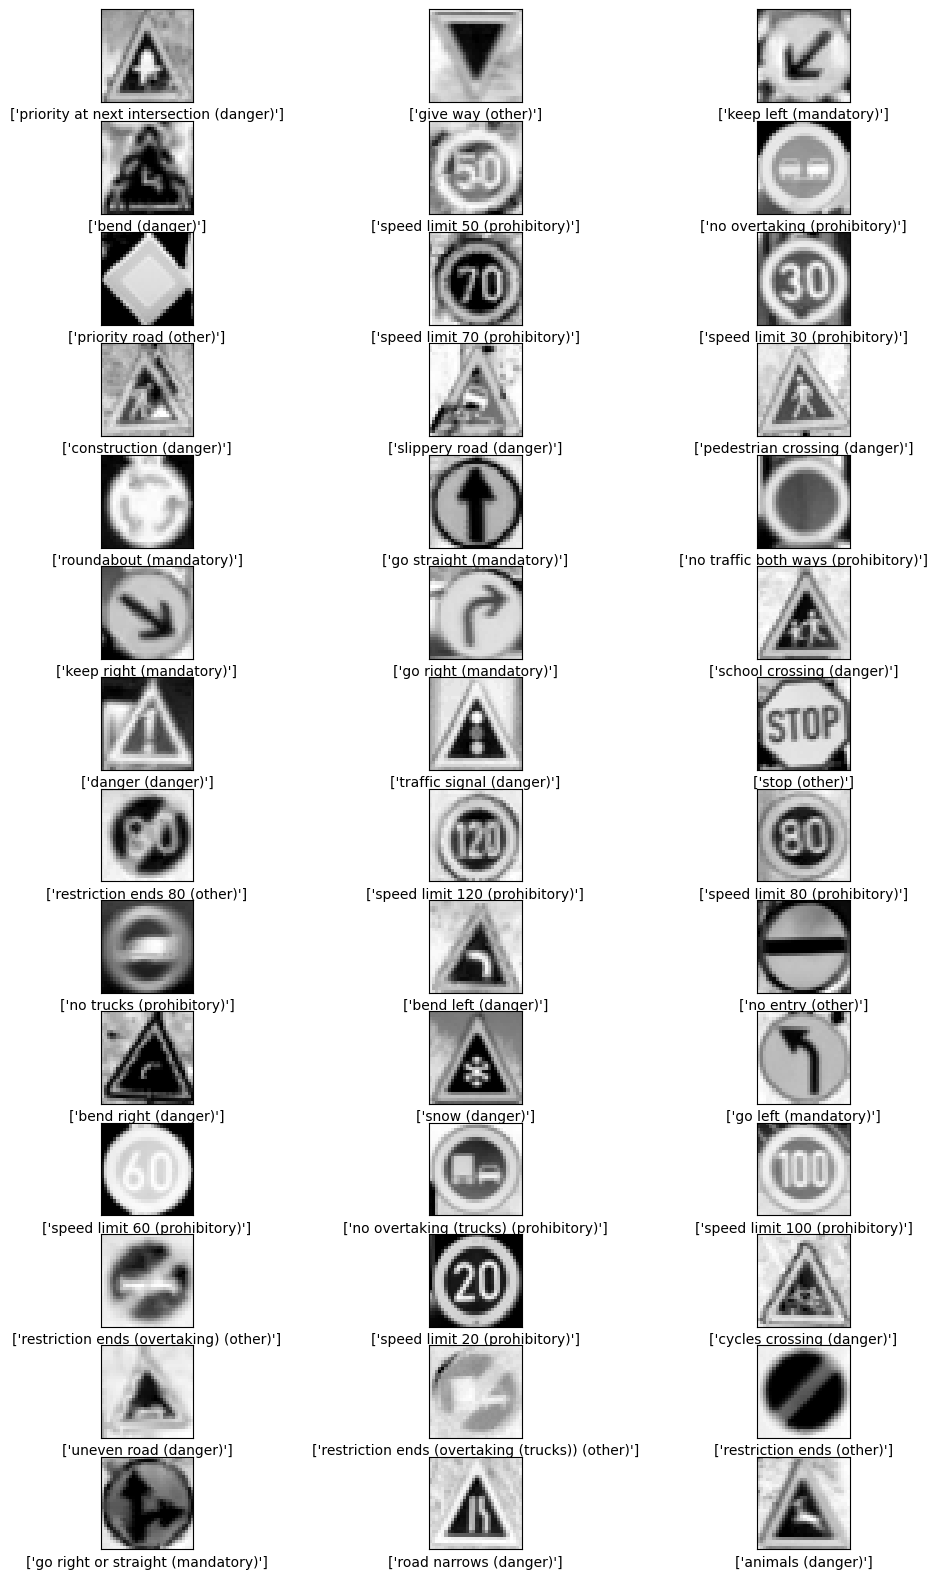

In [5]:
np.random.seed(42)    # Random seed
plt.figure(figsize=(12,20))    # Figure size
lbls = list(df2['label'].unique())     # Unique label values
for i,lbl in enumerate(lbls):     # For each label
    df_temp = df2[df2['label']== lbl]    # Filtering dataset
    rows = df_temp.shape[0]
    row = np.random.randint(low = 0,high= rows,size=1)   # grabbing random row index
    arr = df_temp.iloc[row,0].to_numpy()     # get np-1D array (flattened image)
    image = arr[0].reshape(30,30)    # Reshaping the array to (30,30) matrix (forming image)
    label = df_temp.iloc[row,-1].to_numpy()    # get the label associated with the image
    # Plotting the image and label
    plt.subplot(14,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.reshape(30,30), cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()


#### Plot the distribution of Classes

Text(0.5, 0, 'Counts')

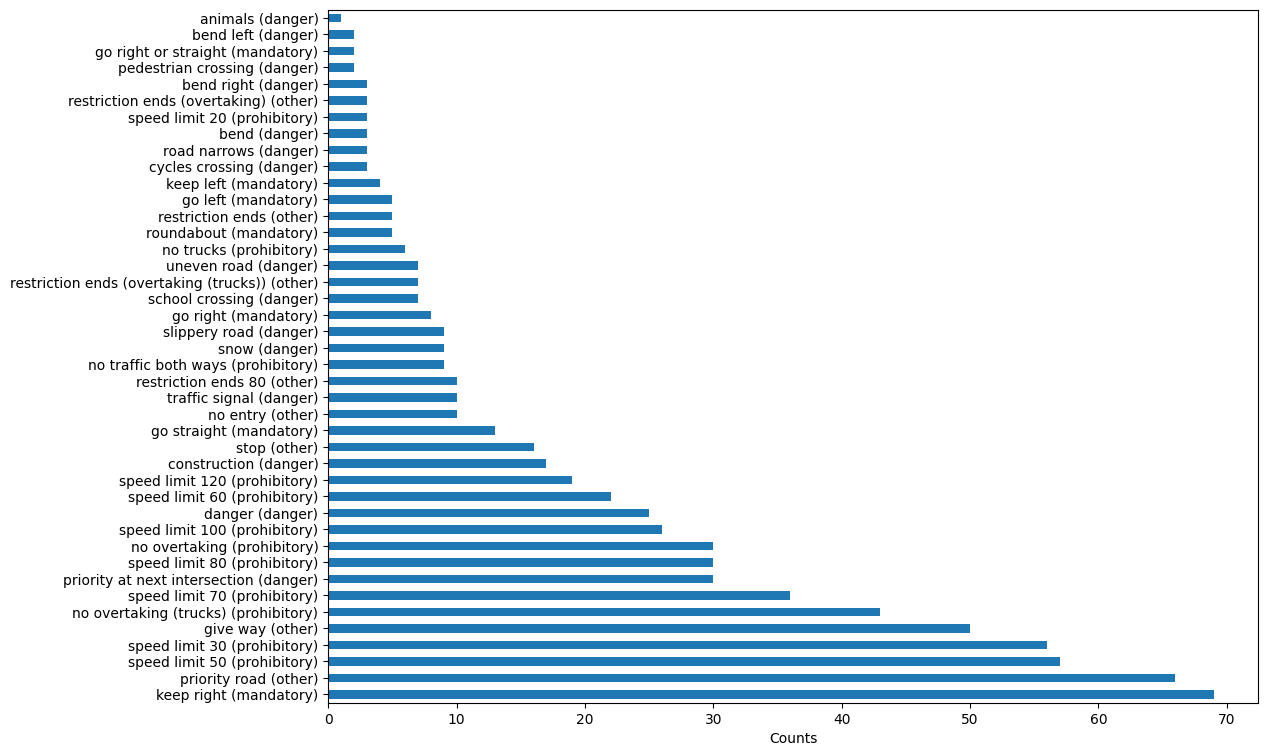

In [6]:
hist = df2['class name'].value_counts()
plt.figure(figsize=(12,9))
hist.plot(kind='barh')
plt.xlabel('Counts')

In [7]:
# ValueError: The least populated class in y has only 1 member, /
# which is too few. The minimum number of groups for any class cannot be less than 2.
train_labels = hist[hist >= 5].index.tolist()
print(train_labels,f'Length = {len(train_labels)}')

['keep right (mandatory)', 'priority road (other)', 'speed limit 50 (prohibitory)', 'speed limit 30 (prohibitory)', 'give way (other)', 'no overtaking (trucks) (prohibitory)', 'speed limit 70 (prohibitory)', 'priority at next intersection (danger)', 'speed limit 80 (prohibitory)', 'no overtaking (prohibitory)', 'speed limit 100 (prohibitory)', 'danger (danger)', 'speed limit 60 (prohibitory)', 'speed limit 120 (prohibitory)', 'construction (danger)', 'stop (other)', 'go straight (mandatory)', 'no entry (other)', 'traffic signal (danger)', 'restriction ends 80 (other)', 'no traffic both ways (prohibitory)', 'snow (danger)', 'slippery road (danger)', 'go right (mandatory)', 'school crossing (danger)', 'restriction ends (overtaking (trucks)) (other)', 'uneven road (danger)', 'no trucks (prohibitory)', 'roundabout (mandatory)', 'restriction ends (other)', 'go left (mandatory)'] Length = 31


In [8]:
def drop_samples_less_than_n (n,df):
    '''Returns index of the dataframe that satisfies the criterion.
    '''
    hist = df['class name'].value_counts()
    train_labels = hist[hist < n].index.tolist()
    idx = set()
    for name in train_labels:
        keep_idx = df[df['class name'] == name].index.values
        idx.update(keep_idx)
    return idx

drop_idx = drop_samples_less_than_n (5,df2)
print('Dropped rows: ',len(drop_idx))
print('Shape of df2: ',df2.shape)
df3 = df2.drop(drop_idx).reset_index(drop= True)
print('Shape of df3: ',df3.shape)
df3.head()

Dropped rows:  29
Shape of df2:  (741, 6)
Shape of df3:  (712, 6)


,numpy image,hog data,histogram,label,file_name,class name
0,"[102, 108, 105, 80, 67, 68, 68, 203, 255, 255,...","[0.10452954518914803, 0.13565473746057752, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,00000,priority at next intersection (danger)
1,"[222, 224, 254, 255, 255, 254, 254, 254, 255, ...","[0.06466393925456124, 0.052403263828257315, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,00001,give way (other)
2,"[255, 247, 238, 251, 248, 199, 143, 95, 127, 1...","[0.18271324642070286, 0.1361120632753625, 0.11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,00004,speed limit 50 (prohibitory)
3,"[29, 25, 24, 23, 24, 22, 20, 21, 20, 19, 22, 6...","[0.05527521644664281, 0.0395694616954475, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",9,00005,no overtaking (prohibitory)
4,"[71, 70, 93, 115, 165, 97, 72, 69, 68, 71, 94,...","[0.32484243567299703, 0.0, 0.0, 0.014565495522...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,00006,speed limit 50 (prohibitory)


In [9]:
# Relabelling numerical lables
class_names = df3['class name'].unique()
new_class_labels = {}
for i, name in enumerate(class_names):
    label = i
    new_class_labels.update({name: label})
    locs = df3[df3['class name']==name].index.values
    for loc in locs:
        df3.iloc[loc,3] = i

In [10]:
df3.head()

,numpy image,hog data,histogram,label,file_name,class name
0,"[102, 108, 105, 80, 67, 68, 68, 203, 255, 255,...","[0.10452954518914803, 0.13565473746057752, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,00000,priority at next intersection (danger)
1,"[222, 224, 254, 255, 255, 254, 254, 254, 255, ...","[0.06466393925456124, 0.052403263828257315, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,00001,give way (other)
2,"[255, 247, 238, 251, 248, 199, 143, 95, 127, 1...","[0.18271324642070286, 0.1361120632753625, 0.11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,00004,speed limit 50 (prohibitory)
3,"[29, 25, 24, 23, 24, 22, 20, 21, 20, 19, 22, 6...","[0.05527521644664281, 0.0395694616954475, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",3,00005,no overtaking (prohibitory)
4,"[71, 70, 93, 115, 165, 97, 72, 69, 68, 71, 94,...","[0.32484243567299703, 0.0, 0.0, 0.014565495522...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,00006,speed limit 50 (prohibitory)


#### Normalize the features

For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values.

Hint: sklearn.preprocessing.normalize

In [11]:
features = ['numpy image', 'hog data', 'histogram']
f1 = df3[features[0]].to_numpy()
f2 = df3[features[1]].to_numpy()
f3 = df3[features[2]].to_numpy()
f1 = np.vstack(f1)
f1 = f1/255
f3 = f3/55
f2 = np.vstack(f2)
f3 = np.vstack(f3)
#print(f3.shape)
X = np.hstack([f1,f2,f3])
print(X.shape)
y = df3['label'].to_numpy()
y = np.vstack(y).ravel()
print(X.shape,y.shape)

(712, 2964)
(712, 2964) (712,)


### Train the MLP classifier on features (1 point)

* Split the data into train and test

* Train the MLP classifier with different parameters

* Get the accuracy score and performance metrics

In [12]:
# split test
X_data, X_test, y_data, y_test = train_test_split(X,y, test_size = 0.3,
                                                    random_state=42,
                                                   stratify= y)
# split train validation
X_train, X_val, y_train, y_val = train_test_split(X_data,y_data, test_size = 0.1,
                                                 random_state= 42,
                                                 stratify= y_data)

print('Full shape: ',X.shape,y.shape)
print('Input data shape: ',X_data.shape,y_data.shape)
print('Test data shape: ',X_test.shape,y_test.shape)
print('Training data shape: ',X_train.shape,y_train.shape)
print('Validation data shape: ',X_val.shape,y_val.shape)

Full shape:  (712, 2964) (712,)
Input data shape:  (498, 2964) (498,)
Test data shape:  (214, 2964) (214,)
Training data shape:  (448, 2964) (448,)
Validation data shape:  (50, 2964) (50,)


In [14]:
from sklearn.metrics import accuracy_score
# MLP classifier initialise
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(512,128,64,32),    # 4 layers having i neurons
    max_iter=1000,
    alpha=1e-4,
    solver="adam",
    verbose=10,
    batch_size= 50,
    random_state=1,
    learning_rate_init= 1e-3,
    early_stopping= True,
    validation_fraction=0.1,
)
history_mdl_clf = mlp_clf.fit(X_data, y_data)
pred = mlp_clf.predict(X_test)
print('Accuracy score: ',accuracy_score(pred, y_test))

Iteration 1, loss = 3.19709978
Validation score: 0.380000
Iteration 2, loss = 2.59207741
Validation score: 0.460000
Iteration 3, loss = 2.11031243
Validation score: 0.540000
Iteration 4, loss = 1.77409131
Validation score: 0.560000
Iteration 5, loss = 1.48353622
Validation score: 0.660000
Iteration 6, loss = 1.20403007
Validation score: 0.820000
Iteration 7, loss = 0.92179180
Validation score: 0.840000
Iteration 8, loss = 0.70938454
Validation score: 0.820000
Iteration 9, loss = 0.53300229
Validation score: 0.840000
Iteration 10, loss = 0.45990389
Validation score: 0.840000
Iteration 11, loss = 0.33145868
Validation score: 0.780000
Iteration 12, loss = 0.29780563
Validation score: 0.840000
Iteration 13, loss = 0.20432926
Validation score: 0.880000
Iteration 14, loss = 0.13009787
Validation score: 0.820000
Iteration 15, loss = 0.08231310
Validation score: 0.860000
Iteration 16, loss = 0.05346687
Validation score: 0.920000
Iteration 17, loss = 0.04119557
Validation score: 0.860000
Iterat

In [15]:
print(history_mdl_clf.loss_curve_,history_mdl_clf.validation_scores_)

[3.1970997778536656, 2.5920774050912736, 2.110312425162338, 1.7740913090081165, 1.4835362237708234, 1.2040300726301323, 0.9217918036330789, 0.7093845407796228, 0.5330022891400863, 0.4599038877050821, 0.3314586833776959, 0.29780563006996236, 0.20432925902485916, 0.13009786933503525, 0.0823131016439842, 0.05346687232179421, 0.041195571902521454, 0.03191410126225498, 0.026683778550135765, 0.0222491421732313, 0.01979604843383723, 0.016589773669984688, 0.013625573926482329, 0.012207318022283186, 0.010682771108192398, 0.009967362799267954, 0.008834175947099676, 0.008231458449689113, 0.007624893594984653, 0.007188084156230983, 0.006737934891195425, 0.006398756332314098, 0.0061282959126885235] [0.38, 0.46, 0.54, 0.56, 0.66, 0.82, 0.84, 0.82, 0.84, 0.84, 0.78, 0.84, 0.88, 0.82, 0.86, 0.92, 0.86, 0.92, 0.92, 0.88, 0.86, 0.94, 0.9, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92]


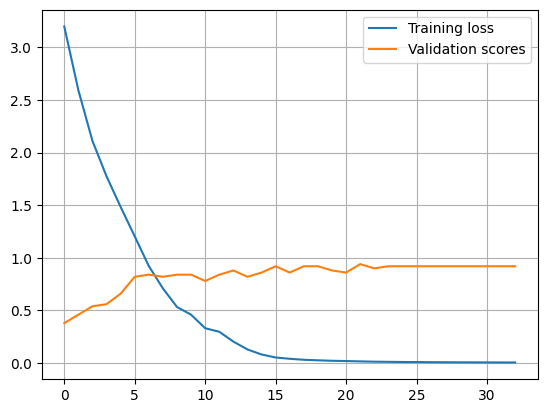

In [16]:
# Model History plot
plt.plot(figsize=(8,5))
plt.plot(history_mdl_clf.loss_curve_,label= 'Training loss')
plt.plot(history_mdl_clf.validation_scores_,label= 'Validation scores')
plt.grid(True)
plt.legend()
#plt.gca().set_ylim(0,1) # Set the y axis between [0,1]
plt.show()

### Tune the hyper-parameters (2 points)

* Use the GridSearchCV or RandomizedSearchCV and select best parameters

  Hint: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

  (or)
* Manually change and find the best parameters

To know about all the parameters, click [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [17]:
# Library imports
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from functools import reduce

def layer_neuron_combi (max_layers, max_exponents_of_2_neurons):
    '''Returns a list of combinations of hidden layers and neurons.
    '''
    layers = max_layers+1
    neurons = max_exponents_of_2_neurons
    list_neurons = [2**n for n in range (neurons,4,-1)]  # Taking reversed list for higher neurons towards input layer
    combis = []
    for layer in range(1,layers):
        combination = combinations(list_neurons,layer)
        combis.append(list(combination))
    return(reduce(list.__add__,combis))

# Parameters Dictionary
param_grid = {
    "hidden_layer_sizes": layer_neuron_combi (max_layers= 4, max_exponents_of_2_neurons= 9),
    "learning_rate_init": reciprocal(3e-4,3e-2), # Distribution of random values between a range
}

#print(layer_neuron_combi (max_layers= 4, max_exponents_of_2_neurons= 9))

In [18]:
print(layer_neuron_combi (max_layers= 4, max_exponents_of_2_neurons= 9))

[(512,), (256,), (128,), (64,), (32,), (512, 256), (512, 128), (512, 64), (512, 32), (256, 128), (256, 64), (256, 32), (128, 64), (128, 32), (64, 32), (512, 256, 128), (512, 256, 64), (512, 256, 32), (512, 128, 64), (512, 128, 32), (512, 64, 32), (256, 128, 64), (256, 128, 32), (256, 64, 32), (128, 64, 32), (512, 256, 128, 64), (512, 256, 128, 32), (512, 256, 64, 32), (512, 128, 64, 32), (256, 128, 64, 32)]


In [19]:
# Using Randomized Search for 
mlp_clf = MLPClassifier(
    max_iter=1000,
    batch_size=50,
    alpha=1e-4,
    solver="adam",
    verbose=10,
    random_state=1,
    early_stopping= True,
    validation_fraction=0.1,
)
rand_search_cv = RandomizedSearchCV(mlp_clf, param_grid, n_iter=300, cv=2)
rand_search_cv.fit(X_data, y_data)

Iteration 1, loss = 4.73679393
Validation score: 0.120000
Iteration 2, loss = 3.27057168
Validation score: 0.120000
Iteration 3, loss = 2.97668833
Validation score: 0.240000
Iteration 4, loss = 2.68114322
Validation score: 0.280000
Iteration 5, loss = 2.49015118
Validation score: 0.360000
Iteration 6, loss = 2.22721676
Validation score: 0.360000
Iteration 7, loss = 2.18682534
Validation score: 0.320000
Iteration 8, loss = 1.89133453
Validation score: 0.400000
Iteration 9, loss = 1.73055257
Validation score: 0.400000
Iteration 10, loss = 1.53345132
Validation score: 0.400000
Iteration 11, loss = 1.36606235
Validation score: 0.400000
Iteration 12, loss = 1.30314452
Validation score: 0.360000
Iteration 13, loss = 1.16519047
Validation score: 0.560000
Iteration 14, loss = 0.85422674
Validation score: 0.520000
Iteration 15, loss = 0.69673908
Validation score: 0.560000
Iteration 16, loss = 0.63207290
Validation score: 0.560000
Iteration 17, loss = 0.46981614
Validation score: 0.520000
Iterat

RandomizedSearchCV(cv=2,
                   estimator=MLPClassifier(batch_size=50, early_stopping=True,
                                           max_iter=1000, random_state=1,
                                           verbose=10),
                   n_iter=300,
                   param_distributions={'hidden_layer_sizes': [(512,), (256,),
                                                               (128,), (64,),
                                                               (32,),
                                                               (512, 256),
                                                               (512, 128),
                                                               (512, 64),
                                                               (512, 32),
                                                               (256, 128),
                                                               (256, 64),
                                                               (256, 32),
                                                               (128, 64),
                                                               (128, 32),
                                                               (64, 32),
                                                               (512, 256, 128),
                                                               (512, 256, 64),
                                                               (512, 256, 32),
                                                               (512, 128, 64),
                                                               (512, 128, 32),
                                                               (512, 64, 32),
                                                               (256, 128, 64),
                                                               (256, 128, 32),
                                                               (256, 64, 32),
                                                               (128, 64, 32),
                                                               (512, 256, 128,
                                                                64),
                                                               (512, 256, 128,
                                                                32),
                                                               (512, 256, 64,
                                                                32),
                                                               (512, 128, 64,
                                                                32),
                                                               (256, 128, 64,
                                                                32)],
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002DC896DA850>})

In [20]:
print("Best estimator found by grid search:")
print(rand_search_cv.best_estimator_)

Best estimator found by grid search:
MLPClassifier(batch_size=50, early_stopping=True, hidden_layer_sizes=(512, 256),
              learning_rate_init=0.0016498279441036817, max_iter=1000,
              random_state=1, verbose=10)


In [21]:
best_mlp_clf = rand_search_cv.best_estimator_
history_best_mdl_clf = best_mlp_clf.fit(X_data, y_data)
pred = best_mlp_clf.predict(X_test)
test_score = accuracy_score(pred, y_test)
print('Accuracy score on Test data: %0.4f' % (test_score))

Iteration 1, loss = 3.07188727
Validation score: 0.320000
Iteration 2, loss = 1.83889227
Validation score: 0.440000
Iteration 3, loss = 1.19243464
Validation score: 0.400000
Iteration 4, loss = 0.86912093
Validation score: 0.700000
Iteration 5, loss = 0.52615450
Validation score: 0.800000
Iteration 6, loss = 0.40216838
Validation score: 0.680000
Iteration 7, loss = 0.26177264
Validation score: 0.760000
Iteration 8, loss = 0.16861190
Validation score: 0.740000
Iteration 9, loss = 0.13539558
Validation score: 0.840000
Iteration 10, loss = 0.07384831
Validation score: 0.800000
Iteration 11, loss = 0.04414698
Validation score: 0.860000
Iteration 12, loss = 0.03144261
Validation score: 0.840000
Iteration 13, loss = 0.02114959
Validation score: 0.860000
Iteration 14, loss = 0.01647587
Validation score: 0.860000
Iteration 15, loss = 0.01335338
Validation score: 0.860000
Iteration 16, loss = 0.01179531
Validation score: 0.880000
Iteration 17, loss = 0.00947827
Validation score: 0.880000
Iterat

In [22]:
string = 'Test score: {}%'.format(round(100*test_score,2))
print(string)

Test score: 88.79%


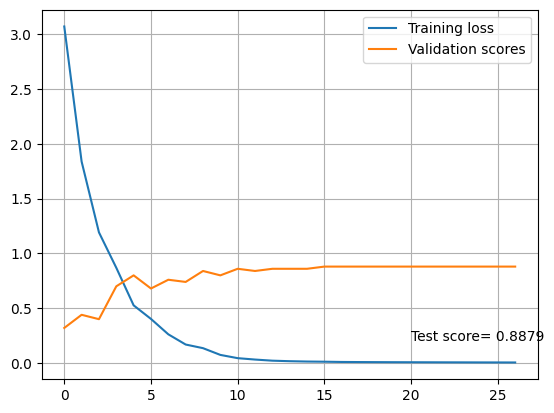

In [23]:
# Model History plot
plt.plot(figsize=(8,5))
plt.plot(history_best_mdl_clf.loss_curve_,label= 'Training loss')
plt.plot(history_best_mdl_clf.validation_scores_,label= 'Validation scores')
plt.grid(True)
plt.legend()
plt.text(20,0.2, 'Test score= {}'.format(round(test_score,4)))
#plt.gca().set_ylim(0,1) # Set the y axis between [0,1]
plt.show()

#### Plotting predictions using Best MLPClassifier model

In [24]:
# #@ Define functions for full set predictions
new_class_names = list(new_class_labels.keys())
def plot_image(i, predictions_arr, true_labels, img):
    true_label, img = int(true_labels), 255.0*img.reshape(30,30)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # showing the image
    plt.imshow(img, cmap= plt.cm.binary)
    # Color coding the predicted labels
    predicted_label = np.argmax(predictions_arr)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel(
        "{} {:2.0f}% ({})".format(new_class_names[predicted_label],
                                 100*np.max(predictions_arr),
                                 new_class_names[true_label],),
                                 color= color,
    )

def plot_value_array(i, predictions_array, true_label):
  true_label = int(true_label)
  plt.grid(False)
  plt.xticks(range(1,32))
  plt.yticks([])
  thisplot = plt.bar(range(1,32), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')





In [25]:
print(new_class_labels)
print(np.argmax(pred[0]), y_test[i])

{'priority at next intersection (danger)': 0, 'give way (other)': 1, 'speed limit 50 (prohibitory)': 2, 'no overtaking (prohibitory)': 3, 'priority road (other)': 4, 'speed limit 70 (prohibitory)': 5, 'speed limit 30 (prohibitory)': 6, 'construction (danger)': 7, 'slippery road (danger)': 8, 'roundabout (mandatory)': 9, 'go straight (mandatory)': 10, 'no traffic both ways (prohibitory)': 11, 'keep right (mandatory)': 12, 'go right (mandatory)': 13, 'school crossing (danger)': 14, 'danger (danger)': 15, 'traffic signal (danger)': 16, 'stop (other)': 17, 'restriction ends 80 (other)': 18, 'speed limit 120 (prohibitory)': 19, 'speed limit 80 (prohibitory)': 20, 'no trucks (prohibitory)': 21, 'no entry (other)': 22, 'snow (danger)': 23, 'go left (mandatory)': 24, 'speed limit 60 (prohibitory)': 25, 'no overtaking (trucks) (prohibitory)': 26, 'speed limit 100 (prohibitory)': 27, 'uneven road (danger)': 28, 'restriction ends (overtaking (trucks)) (other)': 29, 'restriction ends (other)': 30}

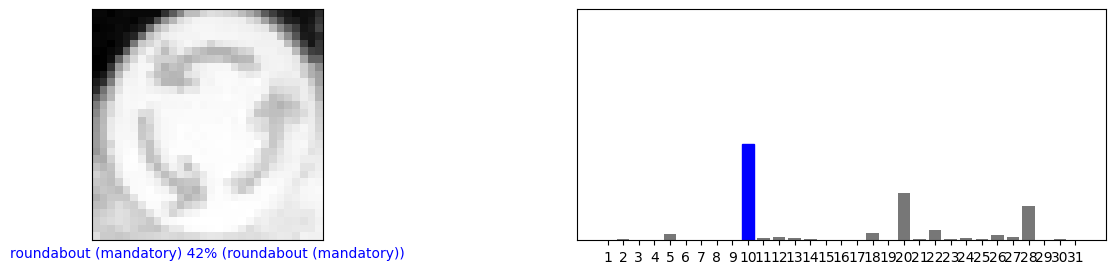

In [26]:
np.random.seed(72)
i = int(np.random.randint(low = 0,high= 213,size=1))
pred = best_mlp_clf.predict_proba([X_test[i]])
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plot_image(i, pred[0], y_test[i], X_test[i][:900])
plt.subplot(1,2,2)
plot_value_array(i, pred[0],  y_test[i])
plt.show()

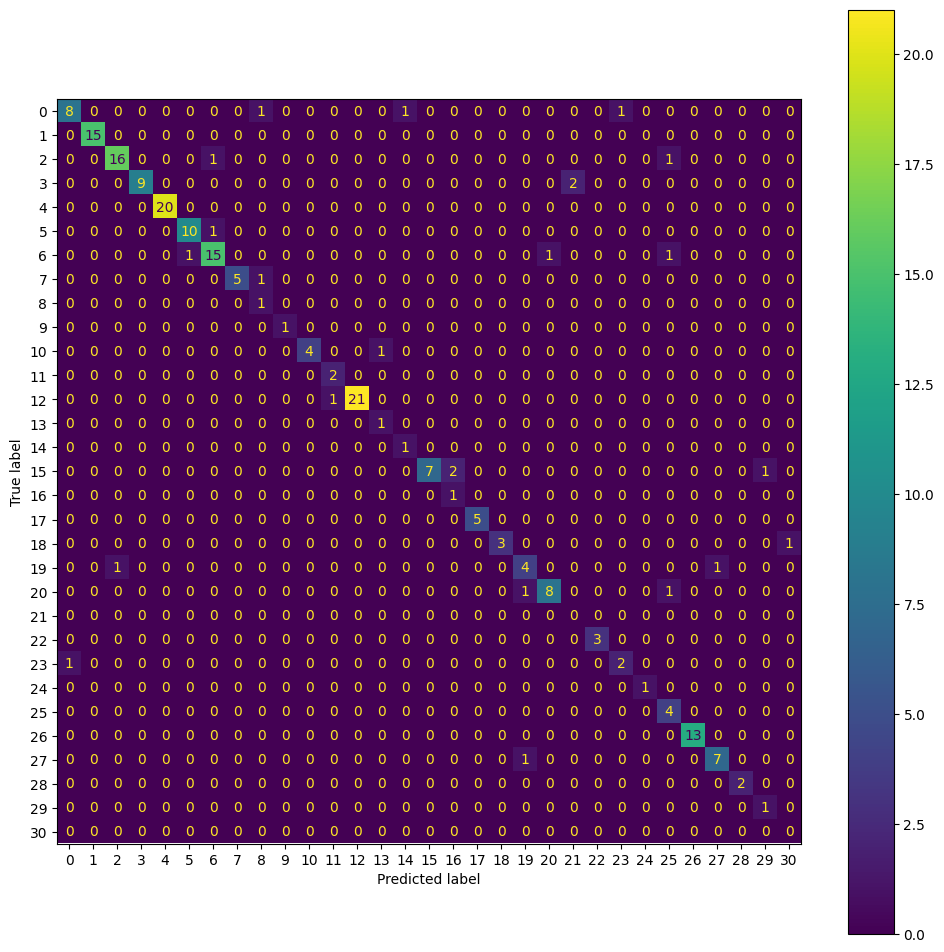

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting confusion matrix
y_predict = best_mlp_clf.predict(X_test)
cm = confusion_matrix(y_predict,y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=np.arange(31))
fig, ax = plt.subplots(figsize=(12,12))
cmp.plot(ax=ax)

#### Try the different algorithms and compare the results with MLP classifier

In [90]:
# Source: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
# https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net (MLP)",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(batch_size=50, early_stopping=True, hidden_layer_sizes=(512,256,),
              learning_rate_init=0.0051147402542354725, max_iter=1000,
              random_state=1, verbose= False),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    #ax = plt.subplot(len(classifiers) + 1,1, i)
    clf = make_pipeline(StandardScaler(), clf)
    # some parameter combinations will not converge so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", category=ConvergenceWarning, module="sklearn"
        )
        warnings.filterwarnings(
            "ignore", category=UserWarning, module="sklearn"
        )
        clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print('Score for {} is {}.'.format(name,round(score,4)))

Score for Nearest Neighbors is 0.6075.
Score for Linear SVM is 0.8505.
Score for RBF SVM is 0.1028.
Score for Gaussian Process is 0.0093.
Score for Decision Tree is 0.4346.
Score for Random Forest is 0.3972.
Score for Neural Net (MLP) is 0.7757.
Score for AdaBoost is 0.243.
Score for Naive Bayes is 0.5421.
Score for QDA is 0.0374.


### Implement simple Neural Networks using keras (3 points)

* Define the keras model and initialize the layers
  - Ensure the input layer has the right number of input features. This can be specified when creating the first layer with the input_dim argument.
* Compile the model
  - Specify the loss function (to evaluate a set of weights), the optimizer (is used to search through different weights for the network) and any optional metrics to collect and report during training.
* Fit and Evaluate the model
  - Fit the data by specifying epochs and evaluate the model

In [13]:
print(tf.__version__)

2.3.0


#### Try the same parameters used for MLP Classifier and build the keras model

In [78]:
# Step 1 - Build the architecture
tf_model_clf = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(2964,)),
        tf.keras.layers.Dense(512, activation= 'relu',),
        tf.keras.layers.Dense(256, activation= 'relu',),
        tf.keras.layers.Dense(31),
    ]
)

In [79]:
# Step 2 - Compile the model
tf_model_clf.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0051147402542354725, amsgrad=False,),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics= ['accuracy',]
)

In [80]:
# Step 3 - Fit and Evaluate the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history_tf_model_clf = tf_model_clf.fit(X_train, y_train, epochs= 20,
                         callbacks = [callback], validation_data= (X_val, y_val))

Epoch 1/20
14/14 [==============================] - 0s 34ms/step - loss: 4.6915 - accuracy: 0.1183 - val_loss: 2.6693 - val_accuracy: 0.3800
Epoch 2/20
14/14 [==============================] - 0s 10ms/step - loss: 2.3214 - accuracy: 0.3661 - val_loss: 1.6161 - val_accuracy: 0.6000
Epoch 3/20
14/14 [==============================] - 0s 12ms/step - loss: 1.4869 - accuracy: 0.5625 - val_loss: 1.2468 - val_accuracy: 0.5600
Epoch 4/20
14/14 [==============================] - 0s 11ms/step - loss: 1.0281 - accuracy: 0.6763 - val_loss: 1.0414 - val_accuracy: 0.6400
Epoch 5/20
14/14 [==============================] - 0s 10ms/step - loss: 0.7569 - accuracy: 0.7701 - val_loss: 0.8055 - val_accuracy: 0.7200
Epoch 6/20
14/14 [==============================] - 0s 11ms/step - loss: 0.4764 - accuracy: 0.8616 - val_loss: 0.7146 - val_accuracy: 0.7600
Epoch 7/20
14/14 [==============================] - 0s 10ms/step - loss: 0.2768 - accuracy: 0.9263 - val_loss: 0.5736 - val_accuracy: 0.8400
Epoch 8/20
14

In [81]:
tf_model_clf.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 2964)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               1518080   
_________________________________________________________________
dense_50 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_51 (Dense)             (None, 31)                7967      
Total params: 1,657,375
Trainable params: 1,657,375
Non-trainable params: 0
_________________________________________________________________


In [82]:
# get hidden layer
hidden1 = tf_model_clf.layers[1]
# Get weights and biases
weights, biases = hidden1.get_weights()
#print('Weights of layer 1: ',weights)
print('Shape of the weights: ',weights.shape)
#print('Biases of layer 1: ',biases)
print('Shape of the biases: ', biases.shape)

Weights of layer 1:  [[-0.04821118 -0.07531263 -0.02448592 ...  0.02988889 -0.01275149
  -0.06683266]
 [-0.05805156 -0.03995259 -0.04926714 ... -0.01881131  0.01891146
  -0.04901871]
 [-0.01011319 -0.02998843 -0.01647829 ... -0.03206491 -0.01051312
   0.00509781]
 ...
 [ 0.06291045 -0.04754347 -0.00574323 ... -0.05532052 -0.03966148
  -0.05257611]
 [-0.00533802  0.0083205  -0.01559004 ... -0.03257516 -0.04391403
  -0.02554676]
 [ 0.03669503  0.03223628  0.00653618 ...  0.06364946  0.00023033
  -0.06616089]]
Shape of the weights:  (2964, 512)
Biases of layer 1:  [-0.03069859 -0.03622024 -0.03070822  0.02189034 -0.02261015 -0.02288672
 -0.03070995  0.01317605  0.01005974 -0.02279257 -0.01419451 -0.03071365
 -0.03059597 -0.01938222 -0.02074851 -0.03069999 -0.0186619  -0.03064484
  0.01071463 -0.03060071 -0.05118253 -0.0228932  -0.01526208 -0.03301618
 -0.03066844 -0.02049914 -0.03070248 -0.03070414 -0.0306983  -0.02195068
 -0.0195818  -0.04062608 -0.03070494 -0.03069794 -0.03070237 -0.023

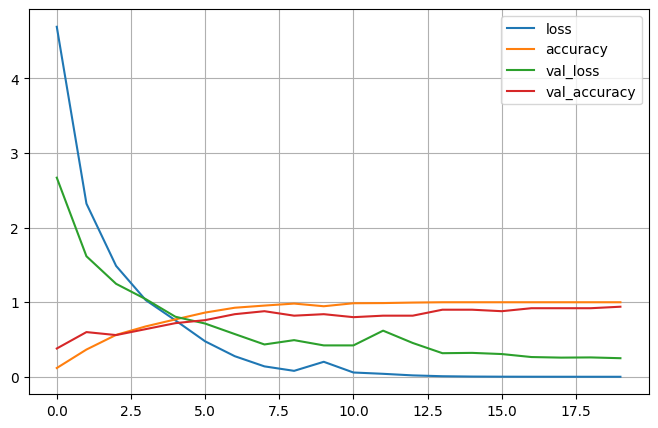

In [83]:
# Model History plot
pd.DataFrame(history_tf_model_clf.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,1) # Set the y axis between [0,1]
plt.show()

#### Predictions with `tf_model_clf`

In [84]:
probability_model = tf.keras.Sequential([tf_model_clf, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test)

In [85]:
tf_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
tf_metrics.update_state(y_test, predictions)
print('Sparse Categorical accuracy on Test data is %0.4f' %  tf_metrics.result().numpy())

Sparse Categorical accuracy on Test data is 0.8224


#### Experiment using Dropout, Regularization and Batch Normalization

#### - Regularization

In [86]:
# Step 1 - Build the architecture
tf_model_clf_L2 = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(2964,)),
        tf.keras.layers.Dense(512, activation= 'relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(256, activation= 'relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(31,),
    ]
)
# Step 2 - Compile model
tf_model_clf_L2.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0051147402542354725, amsgrad=False,),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics= ['accuracy',]
)
# Step 3 - Fit and Evaluate the model
history_tf_model_clf_L2 = tf_model_clf_L2.fit(X_train, y_train, epochs=20,
                         callbacks = [callback], validation_data= (X_val, y_val))
# Step 4 - Predict with trained model and calculate score
probability_model = tf.keras.Sequential([tf_model_clf_L2, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)

Epoch 1/20
14/14 [==============================] - 0s 33ms/step - loss: 10.1716 - accuracy: 0.1674 - val_loss: 6.0824 - val_accuracy: 0.3800
Epoch 2/20
14/14 [==============================] - 0s 17ms/step - loss: 5.0010 - accuracy: 0.3817 - val_loss: 3.7340 - val_accuracy: 0.5200
Epoch 3/20
14/14 [==============================] - 0s 17ms/step - loss: 3.3675 - accuracy: 0.4598 - val_loss: 2.7643 - val_accuracy: 0.5200
Epoch 4/20
14/14 [==============================] - 0s 18ms/step - loss: 2.6879 - accuracy: 0.5312 - val_loss: 2.4408 - val_accuracy: 0.5600
Epoch 5/20
14/14 [==============================] - 0s 17ms/step - loss: 2.2570 - accuracy: 0.6540 - val_loss: 2.2229 - val_accuracy: 0.6400
Epoch 6/20
14/14 [==============================] - 0s 18ms/step - loss: 2.1677 - accuracy: 0.6339 - val_loss: 2.1911 - val_accuracy: 0.6000
Epoch 7/20
14/14 [==============================] - 0s 18ms/step - loss: 2.1218 - accuracy: 0.6585 - val_loss: 2.0976 - val_accuracy: 0.6200
Epoch 8/20
1

In [87]:
tf_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
tf_metrics.update_state(y_test, predictions)
print('Sparse Categorical accuracy of tf_model_clf_L2 on Test data is %0.4f' %  tf_metrics.result().numpy())

Sparse Categorical accuracy of tf_model_clf_L2 on Test data is 0.7757


#### - Dropout

In [88]:
tf_model_clf_3 = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(2964,)),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(512, activation= 'relu',
                              kernel_initializer= tf.keras.initializers.HeNormal(seed=42),
                              kernel_regularizer='l2'
                             ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation= 'relu',
                              kernel_initializer= tf.keras.initializers.HeNormal(seed=42),
                              kernel_regularizer='l2',
                             ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(31,
                             ),
    ]
)
# Step 2 - Compile model
tf_model_clf_3.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0051147402542354725, amsgrad=False,),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics= ['accuracy',]
)
# Step 3 - Fit and Evaluate the model
history_tf_model_clf_3 = tf_model_clf_3.fit(X_train, y_train, epochs= 20,
                         callbacks = [callback], validation_data= (X_val, y_val))
# Step 4 - Predict with trained model and calculate score
probability_model = tf.keras.Sequential([tf_model_clf_3, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)

Epoch 1/20
14/14 [==============================] - 0s 32ms/step - loss: 16.3953 - accuracy: 0.4040 - val_loss: 25.1578 - val_accuracy: 0.1600
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 11.5880 - accuracy: 0.692 - 0s 17ms/step - loss: 11.2118 - accuracy: 0.6987 - val_loss: 10.8837 - val_accuracy: 0.4800
Epoch 3/20
14/14 [==============================] - 0s 17ms/step - loss: 6.6121 - accuracy: 0.8259 - val_loss: 7.1807 - val_accuracy: 0.3000
Epoch 4/20
14/14 [==============================] - 0s 18ms/step - loss: 4.3113 - accuracy: 0.8281 - val_loss: 5.2689 - val_accuracy: 0.4600
Epoch 5/20
14/14 [==============================] - 0s 17ms/step - loss: 3.3959 - accuracy: 0.8348 - val_loss: 5.7182 - val_accuracy: 0.2000
Epoch 6/20
14/14 [==============================] - 0s 17ms/step - loss: 3.1847 - accuracy: 0.8750 - val_loss: 6.4141 - val_accuracy: 0.2200
Epoch 7/20
14/14 [==============================] - 0s 17ms/step - loss: 2.9665 - accuracy: 0.8817 - val_l

In [89]:
tf_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
tf_metrics.update_state(y_test, predictions)
print('Sparse Categorical accuracy of tf_model_clf_3 on Test data is %0.4f' %  tf_metrics.result().numpy())

Sparse Categorical accuracy of tf_model_clf_3 on Test data is 0.2196


### Report Analysis

* According to the confusion matrix, for which sign were the maximum misclassifications observed? Comment on the misclassification, owing to similar appearing traffic signs, if any.
* Comment on the performance of the MLP Classifier
* Discuss the optimal number of layers, activation functions, optimizers etc. that yielded the best accuracy
* Report on training time vs convergence

Reference: J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011.